In [92]:
##### import the necessary modules and set chart style####
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
mpl.style.use('bmh')
import matplotlib.pylab as plt
from datetime import datetime
import statsmodels.api as sm
from pykalman import KalmanFilter
from math import sqrt

In [93]:
# load time series
AUD = pd.read_csv("../data/AUD.csv")
EUR = pd.read_csv("../data/EUR.csv")
GBP = pd.read_csv("../data/GBP.csv")
NZD = pd.read_csv("../data/NZD.csv")

df = AUD.merge(EUR,on='Date').merge(GBP,on='Date').merge(NZD,on='Date')
df.columns = ["Date", "AUD", "EUR", "GBP", "NZD"]
prices_df = df[["AUD", "EUR", "GBP", "NZD"]]
prices_df = prices_df.set_index(df["Date"])

In [94]:
prices_df = prices_df.iloc[6192:,] # from 2009-01-01

In [95]:
def find_cointegrated_pairs(dataframe, critial_level = 0.05):
    n = dataframe.shape[1] # the length of dateframe
    pvalue_matrix = np.ones((n, n)) # initialize the matrix of p
    keys = dataframe.columns # get the column names
    pairs = [] # initilize the list for cointegration
    for i in range(n):
        for j in range(i+1, n): # for j bigger than i
            stock1 = dataframe[keys[i]] # obtain the price of "stock1"
            stock2 = dataframe[keys[j]]# obtain the price of "stock2"
            result = sm.tsa.stattools.coint(stock1, stock2) # get conintegration
            pvalue = result[1] # get the pvalue
            pvalue_matrix[i, j] = pvalue
            if pvalue < critial_level: # if p-value less than the critical level
                pairs.append((keys[i], keys[j], pvalue)) # record the contract with that p-value
    return pvalue_matrix, pairs

In [96]:
val_num = int(len(prices_df)*0.2)

In [97]:
val_num

290

In [98]:
used_stocks = ["AUD", "EUR", "GBP", "NZD"]

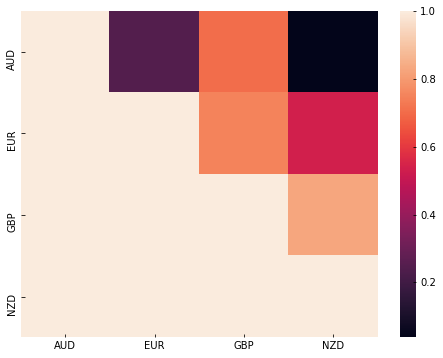

In [99]:
#run our dataframe (up to the split point) of ticker price data through our co-integration function and store results
pvalue_matrix, pairs = find_cointegrated_pairs(prices_df[:-val_num])
#convert our matrix of stored results into a DataFrame
pvalue_matrix_df = pd.DataFrame(pvalue_matrix)
#use Seaborn to plot a heatmap of our results matrix
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(pvalue_matrix_df, xticklabels=used_stocks, yticklabels=used_stocks,ax=ax)
plt.show()

In [100]:
for pair in pairs:
    print("Stock {} and stock {} has a co-integration score of {}".format(pair[0],pair[1],round(pair[2],4)))

Stock AUD and stock NZD has a co-integration score of 0.0378


In [101]:
def KalmanFilterAverage(x):
  # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)
  # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means
# Kalman filter regression
def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
    initial_state_mean=[0,0],
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=2,
    transition_covariance=trans_cov)
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means
def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
    if halflife <= 0:
        halflife = 1
    return halflife

In [118]:
def backtest(df,s1, s2):
    #############################################################
    # INPUT:
    # DataFrame of prices
    # s1: the symbol of contract one
    # s2: the symbol of contract two
    # x: the price series of contract one
    # y: the price series of contract two
    # OUTPUT:
    # df1['cum rets']: cumulative returns in pandas data frame
    # sharpe: Sharpe ratio
    # CAGR: Compound Annual Growth Rate
    x = df[s1]
    y = df[s2]
    # run regression (including Kalman Filter) to find hedge ratio and then create spread series
    df1 = pd.DataFrame({'y':y,'x':x})
    df1.index = pd.to_datetime(df1.index, unit="D")
    state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))
    df1['hr'] = - state_means[:,0]
    df1['spread'] = df1.y + (df1.x * df1.hr)
    # calculate half life
    halflife = half_life(df1['spread'])
    # calculate z-score with window = half life period
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    print(meanSpread)
    df1['zScore'] = (df1.spread-meanSpread)/stdSpread
    ##############################################################
    # trading logic
    entryZscore = 0.75
    exitZscore = 0
    #set up num units long
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0 
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad') 
    #set up num units short 
    df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')
    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)
    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1
    ##############################################################
    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0
    ##############################################################
    start_val = 1
    end_val = df1['cum rets'].iat[-1]
    start_date = df1.iloc[0].name
    end_date = df1.iloc[-1].name
    days = (end_date - start_date).days
    CAGR = round(((float(end_val) / float(start_val)) ** (252.0/days)) - 1,4)
    df1[s1+ " "+s2] = df1['cum rets']
    return df1[s1+" "+s2], sharpe, CAGR

Date
2088-06-21         NaN
2088-06-22         NaN
2088-06-23         NaN
2088-06-26    0.540718
2088-06-27    0.511487
2088-06-28    0.490997
2088-06-29    0.474656
2088-06-30    0.461837
2088-07-03    0.450875
2088-07-04    0.443530
2088-07-05    0.438555
2088-07-06    0.435218
2088-07-07    0.434213
2088-07-10    0.432747
2088-07-11    0.431159
2088-07-12    0.428324
2088-07-13    0.425214
2088-07-14    0.421518
2088-07-17    0.418618
2088-07-18    0.417196
2088-07-19    0.416286
2088-07-20    0.415009
2088-07-21    0.414814
2088-07-24    0.414013
2088-07-25    0.412770
2088-07-26    0.413289
2088-07-27    0.412277
2088-07-28    0.411343
2088-07-31    0.411523
2088-08-01    0.410756
                ...   
2089-06-20    0.384857
2089-06-21    0.386869
2089-06-22    0.388497
2089-06-25    0.390028
2089-06-26    0.392083
2089-06-27    0.393969
2089-06-28    0.396034
2089-06-29    0.397952
2089-07-02    0.398635
2089-07-03    0.398327
2089-07-04    0.398226
2089-07-05    0.397473
2089-0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The pair AUD and NZD produced a Sharpe Ratio of -0.62 and a CAGR of -0.0172


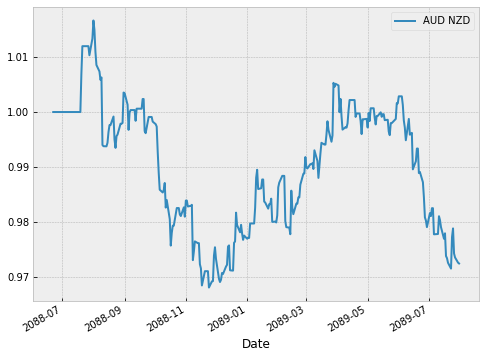

In [119]:
results = []
for pair in pairs:
    rets, sharpe,  CAGR = backtest(prices_df[-val_num:],pair[0],pair[1])
    results.append(rets)
    print("The pair {} and {} produced a Sharpe Ratio of {} and a CAGR of {}".format(pair[0],pair[1],round(sharpe,2),round(CAGR,4)))
    rets.plot(figsize=(8,6),legend=True)